In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchsummary

def advanced_ternarize(weights, beta=0.05):
    delta_th = beta * weights.abs().max()
    
    mask = weights.abs() >= delta_th

    scaling_factor = weights[mask].abs().mean()
    
    ternarized_weights = torch.zeros_like(weights)
    ternarized_weights[weights > delta_th] = scaling_factor
    ternarized_weights[weights < -delta_th] = -scaling_factor
    
    return ternarized_weights

class TernaryConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, bias=True):
        super(TernaryConv, self).__init__()
        self.stride = stride
        self.padding = padding
        self.weight = nn.Parameter(torch.randn(out_channels, in_channels, kernel_size, kernel_size) * 0.01)
        self.bias = nn.Parameter(torch.zeros(out_channels)) if bias else None

    def forward(self, x):
        tern_weights = advanced_ternarize(self.weight)
        return F.conv2d(x, tern_weights, self.bias, self.stride, self.padding)

class TernaryLinear(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super(TernaryLinear, self).__init__()
        self.weight = nn.Parameter(torch.randn(out_features, in_features) * 0.01)
        self.bias = nn.Parameter(torch.zeros(out_features)) if bias else None

    def forward(self, x):
        tern_weights = advanced_ternarize(self.weight)
        return F.linear(x, tern_weights, self.bias)

In [2]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = TernaryConv(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = TernaryConv(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                TernaryConv(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, padding=0),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [3]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=1000):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = TernaryConv(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = TernaryLinear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def resnet18(num_classes=1000):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

Epoch 41: Train Loss: 0.0717, Train Acc: 0.9798, Val Loss: 1.2929, Val Acc: 0.6765
Epoch 42: Train Loss: 0.0280, Train Acc: 0.9936, Val Loss: 0.8603, Val Acc: 0.7941
Epoch 43: Train Loss: 0.0117, Train Acc: 0.9991, Val Loss: 0.7078, Val Acc: 0.8309
Epoch 44: Train Loss: 0.0085, Train Acc: 0.9991, Val Loss: 0.9340, Val Acc: 0.8015
Epoch 45: Train Loss: 0.0056, Train Acc: 1.0000, Val Loss: 0.8265, Val Acc: 0.7868
Epoch 46: Train Loss: 0.0031, Train Acc: 1.0000, Val Loss: 0.8934, Val Acc: 0.8125
Epoch 47: Train Loss: 0.0140, Train Acc: 0.9972, Val Loss: 0.9223, Val Acc: 0.7831
Epoch 48: Train Loss: 0.0218, Train Acc: 0.9936, Val Loss: 0.8246, Val Acc: 0.8051
Epoch 49: Train Loss: 0.0195, Train Acc: 0.9954, Val Loss: 1.2198, Val Acc: 0.7831
Epoch 50: Train Loss: 0.1042, Train Acc: 0.9651, Val Loss: 3.0271, Val Acc: 0.5882
Epoch 51: Train Loss: 0.1823, Train Acc: 0.9412, Val Loss: 2.2192, Val Acc: 0.5882
Epoch 52: Train Loss: 0.0947, Train Acc: 0.9697, Val Loss: 1.9268, Val Acc: 0.6176
Epoc

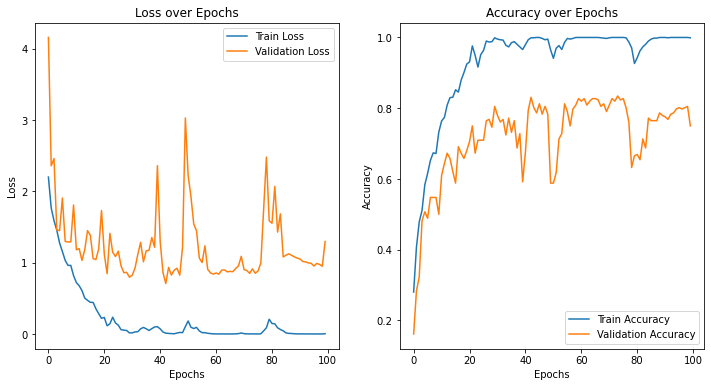

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import pandas as pd
import os
import matplotlib.pyplot as plt
from torchsummary import summary
import time

class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir  # Base directory where images are stored
        self.transform = transform
        self.label_map = {label: index for index, label in enumerate(sorted(set(self.data_frame.iloc[:, 1])))}

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        # Construct the full path to the image by combining root_dir with the relative path from the CSV
        img_name = os.path.join(self.root_dir, self.data_frame.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')  # Open the image and convert to RGB
        label_str = self.data_frame.iloc[idx, 1]
        label = self.label_map[label_str]  # Map the label string to a unique integer

        if self.transform:
            image = self.transform(image)  # Apply transformation, if any

        return image, label

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Initialize dataset and data loader
train_dataset = CustomDataset(
    csv_file='/Users/helenzhao/Desktop/COMP3340/labels_updated.csv',
    root_dir='/Users/helenzhao/Desktop/COMP3340/jpg_labeled',
    transform=transform
)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Initialize model
model = models.resnet18(weights = None)
model.fc = nn.Linear(model.fc.in_features, 17)

# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Print model summary for MACCs
summary(model, input_size=(3, 224, 224))

start_time = time.time()

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(100):
    model.train()
    running_loss, train_correct, train_total = 0.0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = train_correct / train_total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss = criterion(outputs, labels)
            val_running_loss += val_loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(val_loader)
    val_accuracy = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

end_time = time.time()
time_lapsed = end_time - start_time
print(f'Total training time: {time_lapsed / 1000:.2f} seconds')

# Plotting
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()